# Optimized Sphere Strings

In [5]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from quantum_circuits import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Test

## Recover Map

In [6]:
def generate_map_data(channel_target, inputs_map, noise = 0):
    d = channel_target.d
    U_prep, U_basis = inputs_map

    N_map = U_prep.shape[0]
    init = np.zeros((d,d))
    init[0,0] = 1
    init = tf.cast(init, dtype=precision)
    
    state = tf.repeat(tf.expand_dims(init, axis=0), N_map, axis=0)
    state = apply_unitary(state, U_prep)
    state = channel_target.apply_channel(state)
    targets_map = measurement(state, U_basis)
    
    #add noise
    targets_map = add_noise_to_probs(targets_map, noise=noise)
    
    return targets_map


def model_pipeline(channel_target, noise):
    # Make Benchmark
    #################################################################################
    n = 3
    d = 2**n
    
    spam_target = generate_spam_benchmark(n=n, c1=0.8, c2=0.8)
    inputs_spam, targets_spam = generate_spam_data(spam_target, N_spam=None, noise=noise)

    inputs_map, targets_map = generate_map_data(channel_target, spam_target, N_map=2000, noise=noise)
    #################################################################################

    # Fit Models
    #################################################################################
    spam_model = SPAM(init = InitialState(d, c = None),
                      povm = CorruptionMatrix(d, c = None),
                      optimizer = tf.optimizers.Adam(learning_rate=0.01))
    
    spam_model.pretrain(300)

    spam_model.train(inputs = inputs_spam,
                     targets = targets_spam,
                     num_iter = 2000,
                     verbose = False,
                    )

    model = ModelQuantumMap(channel = KrausMap(d = d, 
                                               rank = d**2,
                                               spam = spam_model,
                                              ),
                            loss_function = ProbabilityMSE(),
                            optimizer = tf.optimizers.Adam(learning_rate=0.01),
                            logger = Logger(loss_function = ProbabilityMSE(),
                                            loss_function_val = channel_fidelity_loss),
                           )

    model.train(inputs = inputs_map,
                targets = targets_map,
                inputs_val = None,
                targets_val = [channel_target],
                num_iter = 2000,
                N = 500,
                )
    #################################################################################

    return model

In [7]:
n = 3
d = 2**n

N = 200

#Pauli Strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs_map1, _ = generate_pauli_circuits(n=n, N=N)


#Unoptimized Sphere strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings = SphereStrings(N=2*N, n=n)

_, U2 = strings.generate_circuits()
inputs_map2 = [U2[:N], U2[N:]]


#Optimized Sphere Strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings1 = SphereStrings(N=N, n=n)
strings2 = SphereStrings(N=N, n=n)
strings1.optimize(100)
strings2.optimize(100)

_, U1 = strings1.generate_circuits()
_, U2 = strings2.generate_circuits()
inputs_map3 = [U1, U2]


#Haar Strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings = HaarStrings(N=2*N, n=n)

_, U4 = strings.generate_circuits()
inputs_map4 = [U4[:N], U4[N:]]

#Haar Input
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings = HaarInput(N=2*N, n=n)

_, U5 = strings.generate_circuits()
inputs_map5 = [U5[:N], U5[N:]]

  0%|          | 0/100 [00:00<?, ?it/s]

tf.Tensor((0.08764314861310517+2.8850349999490184e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08721764504987556+1.897699608424517e-18j), shape=(), dtype=complex128)
tf.Tensor((0.0868070451865298+5.731332500345772e-18j), shape=(), dtype=complex128)
tf.Tensor((0.086416204610015+1.2577485422825195e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08604673392666476+5.13162822395366e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08569922828447477-4.7469054084469436e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08537376496330587-1.6933401297303824e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08507009508799362-1.0819619977673896e-18j), shape=(), dtype=complex128)
tf.Tensor((0.0847877354742431+7.055897021288386e-19j), shape=(), dtype=complex128)
tf.Tensor((0.0845260223071796+9.327770889842703e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08428413737145743+4.841620519230465e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08406113537620306-1.2077076254755168e-18j), shape=(), dtype=comp

tf.Tensor((0.08110347885472054+1.1226487119319445e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08110178411909325-1.8244037902453043e-18j), shape=(), dtype=complex128)


  0%|          | 0/100 [00:00<?, ?it/s]

tf.Tensor((0.08733711308252141+4.121422405749253e-18j), shape=(), dtype=complex128)
tf.Tensor((0.0869436864070475+6.204156312896942e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08656525426825924-2.61228768360167e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08620631005118426+6.027915720169018e-18j), shape=(), dtype=complex128)
tf.Tensor((0.0858680430127321-1.274865207677404e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08555060593011479+1.2625008457108012e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08525368403629971+2.9571479799328514e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08497668037431368-3.6887593422682254e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08471881410690911-6.417085632166401e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08447919199720075+5.594944816865139e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08425684206802889-4.770732072712184e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08405074102654667+7.909053131120613e-19j), shape=(), dtype=comp

tf.Tensor((0.08109940436229078+2.866364282833069e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08109777771900087+3.1183951131258285e-18j), shape=(), dtype=complex128)


### Vanilla Pauli Strings

In [8]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_target = KrausMap(d, rank = 10)
targets_map1 = generate_map_data(kraus_target, inputs_map1)

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=10,                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(),
                                               loss_function_val = channel_fidelity_loss),
                               )

model.train(inputs = inputs_map1,
            targets = targets_map1,
            inputs_val = None,
            targets_val = [kraus_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.18097837914320913 -0.11739889641887152
0.027039454579888923 -0.3028814308343025
0.009548823961902387 -0.4062952448311558
0.005322010939218258 -0.46110926342181346
0.0036065869411150346 -0.4977802782591078
0.0026375314992833397 -0.5263743791321104
0.0019987588985688315 -0.5501014918033419
0.0015591662698223325 -0.5704705107045535
0.0012575150499837806 -0.5880854596656826
0.0010462889749269268 -0.6032324989637017
0.0008944840818494003 -0.6161279183769703
0.0007834477999289333 -0.6270499543944403
0.0006997665870734612 -0.6363876115272228
0.0006331885362238443 -0.644556345222924
0.0005770602475617054 -0.6519068972617461
0.0005283311528828983 -0.6587049761446668
0.00048620072130789297 -0.6651372861592793
0.00045026420544771084 -0.6713140076196957
0.00041954342530214005 -0.6772829201153966
0.0003926540927659839 -0.6830636642259935
0.0003683388712510925 -0.6886828825948114


### Unoptimized Sphere Strings

In [10]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_target = KrausMap(d, rank = 10)
targets_map2 = generate_map_data(kraus_target, inputs_map2)

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=10,                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(),
                                               loss_function_val = channel_fidelity_loss),
                               )

model.train(inputs = inputs_map2,
            targets = targets_map2,
            inputs_val = None,
            targets_val = [kraus_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.17790484433432638 -0.11739889641887152
0.028193261573609824 -0.262002982861162
0.01068602531182841 -0.3713005655904098
0.0062839316078375455 -0.4364963978188173
0.0042951804294935544 -0.48167259304736126
0.003166045702194623 -0.5158166482895927
0.0024269450336725155 -0.5427979819670644
0.0019137329887935067 -0.5650020833719887
0.0015562628361845971 -0.5840432987433818
0.0013051278959184814 -0.6009830694984887
0.0011205278757826418 -0.6165508384747163
0.000975537425891905 -0.6311063918251697
0.0008560701164900475 -0.6447578713890739
0.0007561546798883905 -0.657593520093524
0.00067313697998824 -0.6697709770301993
0.0006048303141959748 -0.681460676381994
0.0005485189061550108 -0.6927781909487545
0.000501308496131791 -0.7037815004246888
0.000460744440607155 -0.7145064543276721
0.00042500191549618086 -0.7249878274155205
0.00039280342432949504 -0.7352502173660262


### Optimized Sphere Strings

In [11]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_target = KrausMap(d, rank = 10)
targets_map3 = generate_map_data(kraus_target, inputs_map3)

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=10,                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(),
                                               loss_function_val = channel_fidelity_loss),
                               )

model.train(inputs = inputs_map3,
            targets = targets_map3,
            inputs_val = None,
            targets_val = [kraus_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.1742282843284739 -0.11739889641887152
0.028095587818022186 -0.2643702050174663
0.011272904082503794 -0.36051627480503623
0.0063920672064584245 -0.41690110571085404
0.0039975417288221245 -0.4629722626081997
0.002730475725310141 -0.5003158116840449
0.00203200003797323 -0.5292734358628512
0.0016135224909378959 -0.5515572244016739
0.0013435352629417496 -0.5695337006606839
0.0011524903405218238 -0.5850240794511734
0.001005652660794198 -0.5988819950421789
0.0008880913345095693 -0.6113801590884986
0.0007929316544548644 -0.622793512402816
0.0007149339781347855 -0.6334923152675392
0.0006494475531983779 -0.6437673640222619
0.0005932513659924574 -0.6537346775959422
0.0005444174823667562 -0.6633788089340305
0.0005016184421212051 -0.6726424538730077
0.00046388907405775487 -0.6814745269893142
0.00043063991443754985 -0.6898409130250199
0.00040152009328716444 -0.697746689170194


### Haar Strings

In [14]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_target = KrausMap(d, rank = 10)
targets_map4 = generate_map_data(kraus_target, inputs_map4, noise = 0.01)

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=10,                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(),
                                               loss_function_val = channel_fidelity_loss),
                               )

model.train(inputs = inputs_map4,
            targets = targets_map4,
            inputs_val = None,
            targets_val = [kraus_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.16817437749616573 -0.11739889641887152
0.026232614542948625 -0.2698103214698253
0.01033151531665743 -0.3552256744158069
0.005842409646255761 -0.4096938679051498
0.003913753096211425 -0.45146186229974017
0.002895110093253382 -0.48618951404221405


KeyboardInterrupt: 

### Haar Input

In [16]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_target = KrausMap(d, rank = 10)
targets_map5 = generate_map_data(kraus_target, inputs_map5, noise = 0.01)

model = ModelQuantumMap(channel = KrausMap(d=d, 
                                           rank=10,                                                  ),
                               loss_function = ProbabilityMSE(),
                               optimizer = tf.optimizers.Adam(learning_rate=0.01),
                               logger = Logger(loss_function = ProbabilityMSE(),
                                               loss_function_val = channel_fidelity_loss),
                               )

model.train(inputs = inputs_map5,
            targets = targets_map5,
            inputs_val = None,
            targets_val = [kraus_target],
            num_iter = 2000,
            N = 500,
            )

  0%|          | 0/2000 [00:00<?, ?it/s]

0.19092184845169924 -0.11739889641887152
0.034125635726767474 -0.32908924956224406
0.012353603007879257 -0.4703786837654968
0.006459081599103614 -0.5535285038783806
0.0041895746423488735 -0.6148651762154697
0.0029685907109466003 -0.6605636434137961
0.0022129362615303017 -0.6954549455778752
0.001722927059268084 -0.72380691401136
0.0013903975650561234 -0.7483037905896777
0.0011497674709116668 -0.7705844547891953
0.0009635007179021251 -0.791544781323935
0.0008178710739555229 -0.8112372859271703
0.0007074123000992351 -0.8292914010511732
0.0006231942563736937 -0.8454972409651667
0.000556111462933007 -0.8599486741503563
0.0005003307419444953 -0.8729162500772545
0.00045288069677672184 -0.8847089769698327
0.00041228284329816007 -0.895599185131943
0.00037745144958626617 -0.9058268995278911
0.00034703862365712294 -0.9156223682254366
0.0003194541646534809 -0.9251993922578409


## Overfitting

In [5]:
n = 3
d = 2**n
N = 2000

#Pauli Strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs_map, _ = generate_pauli_circuits(n=n, N=2*N)

inputs_train1 = [inputs_map[0][:N], inputs_map[1][:N]]
inputs_test1 = [inputs_map[0][N:], inputs_map[1][N:]]

### Haar Strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings = HaarStrings(N=4*N, n=n)

_, U = strings.generate_circuits()
inputs_train2 = [U[:N], U[N:2*N]]
inputs_test2 = [U[2*N:3*N], U[3*N:]]

### Haar Input
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings = HaarInput(N=4*N, n=n)

_, U = strings.generate_circuits()
inputs_train3 = [U[:N], U[N:2*N]]
inputs_test3 = [U[2*N:3*N], U[3*N:]]

In [6]:
n = 3
d = 2**n
rank = 4

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

kraus_target = KrausMap(d, rank = rank)

targets_train1 = generate_map_data(kraus_target, inputs_train1, noise=0.01)
targets_test1 = generate_map_data(kraus_target, inputs_test1, noise=0.01)

targets_train2 = generate_map_data(kraus_target, inputs_train2, noise=0.01)
targets_test2 = generate_map_data(kraus_target, inputs_test2, noise=0.01)

targets_train3 = generate_map_data(kraus_target, inputs_train3, noise=0.01)
targets_test3 = generate_map_data(kraus_target, inputs_test3, noise=0.01)

model_list1 = []
model_list2 = []
model_list3 = []
for i in range(1,9):
    np.random.seed(43)
    random.seed(43)
    tf.random.set_seed(43)

    model1 = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=i,                                                  ),
                                   loss_function = KLDiv(),
                                   optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                   logger = Logger(loss_function = KLDiv(),
                                                   loss_function_val = KLDiv()),
                                   )

    model1.train(inputs = inputs_train1,
                targets = targets_train1,
                inputs_val = inputs_test1,
                targets_val = targets_test1,
                num_iter = 4000,
                N = 500,
                )
    
    model_list1.append(model1)
    
    np.random.seed(43)
    random.seed(43)
    tf.random.set_seed(43)
    
    model2 = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=i,                                                  ),
                                   loss_function = KLDiv(),
                                   optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                   logger = Logger(loss_function = KLDiv(),
                                                   loss_function_val = KLDiv()),
                                   )

    model2.train(inputs = inputs_train1,
                targets = targets_train1,
                inputs_val = inputs_test2,
                targets_val = targets_test2,
                num_iter = 4000,
                N = 500,
                )
    
    model_list2.append(model2)
    
    np.random.seed(43)
    random.seed(43)
    tf.random.set_seed(43)
    
    model3 = ModelQuantumMap(channel = KrausMap(d=d, 
                                               rank=i,                                                  ),
                                   loss_function = KLDiv(),
                                   optimizer = tf.optimizers.Adam(learning_rate=0.01),
                                   logger = Logger(loss_function = KLDiv(),
                                                   loss_function_val = KLDiv()),
                                   )

    model3.train(inputs = inputs_train1,
                targets = targets_train1,
                inputs_val = inputs_test3,
                targets_val = targets_test3,
                num_iter = 4000,
                N = 500,
                )
    
    model_list3.append(model3)
    
    

  0%|          | 0/4000 [00:00<?, ?it/s]

0.630426144566094 0.6203670580876056
0.5597008500239442 0.5824983557117822
0.5426543569656154 0.5708759618337457
0.531562723863833 0.569843683049598
0.5280484627405269 0.5672779125917341
0.5173169996294451 0.5692940805968112
0.5080897043249228 0.5679174949589892
0.5018226650150239 0.5608781883511342
0.49930245995952405 0.5563621949195098
0.4925792631535146 0.5535320878090515
0.4862083502454326 0.5438195705266878
0.4798937514870555 0.5316347161349276
0.4771574644122134 0.5284512909991356
0.4661133122417184 0.516639770549441
0.45766968925500817 0.5031079899258918
0.45409434850945685 0.49715950761315086
0.44560361827158146 0.4807677009154782
0.44044111607515585 0.4723847713089597
0.43069977704829376 0.4616624479517718
0.4259139938597825 0.4520784167845929
0.4177109113145165 0.4444679943912554
0.413634374899244 0.4444864132798519
0.40565111518870617 0.4427552297266802
0.4032188092211369 0.4402204868786938
0.39897302798213197 0.4370819207384603
0.39521935088314547 0.4340704372340892
0.39207

  0%|          | 0/4000 [00:00<?, ?it/s]

0.630426144566094 0.6203764531410676
0.5597008500239442 0.5882632560323711
0.5426543569656154 0.5737643479730282
0.531562723863833 0.5644488516366246
0.5280484627405269 0.5596129429915173
0.5173169996294451 0.5544781680423946
0.5080897043249228 0.5508786403040957
0.5018226650150239 0.5468629826313838
0.49930245995952405 0.5452555687304219
0.4925792631535146 0.5338136560515406
0.4862083502454326 0.531611482672029
0.4798937514870555 0.5260649110508078
0.4771574644122134 0.5179568404732668
0.4661133122417184 0.5062731787712785
0.45766968925500817 0.4974176373798214
0.45409434850945685 0.49490269836838946
0.44560361827158146 0.47920991334920654
0.44044111607515585 0.46637563426381334
0.43069977704829376 0.45377660222846083
0.4259139938597825 0.44208305894520317
0.4177109113145165 0.4355608071670463
0.413634374899244 0.43010497963759897
0.40565111518870617 0.4228399220139354
0.4032188092211369 0.41828145623735086
0.39897302798213197 0.41267375464196265
0.39521935088314547 0.4096609351678307

  0%|          | 0/4000 [00:00<?, ?it/s]

0.630426144566094 0.6251377929946756
0.5597008500239442 0.6293080282256417
0.5426543569656154 0.6338556071213503
0.531562723863833 0.6326148401254982
0.5280484627405269 0.6270187567505083
0.5173169996294451 0.618499251249106
0.5080897043249228 0.6177575903891602
0.5018226650150239 0.6085966010812217
0.49930245995952405 0.6072099089878696
0.4925792631535146 0.6036054700691782
0.4862083502454326 0.5929624190604125
0.4798937514870555 0.5850754165600476
0.4771574644122134 0.573758638976061
0.4661133122417184 0.5614366792390284
0.45766968925500817 0.547332453281642
0.45409434850945685 0.540974397162031
0.44560361827158146 0.5299728656819948
0.44044111607515585 0.5161114734316545
0.43069977704829376 0.5063390565224313
0.4259139938597825 0.49537159483475285
0.4177109113145165 0.4877056151487136
0.413634374899244 0.48163074142638346
0.40565111518870617 0.4802062755772702
0.4032188092211369 0.4790694341242336
0.39897302798213197 0.474919342856575
0.39521935088314547 0.4713982570297883
0.3920736

  0%|          | 0/4000 [00:00<?, ?it/s]

0.33522058799663396 0.3309071978690604
0.21378320015113791 0.22918361236653212
0.15378456679028618 0.16904834815036013
0.1221980579290007 0.13892395137795865
0.10337615163915238 0.11622031614847231
0.09185224527494032 0.10070992628294857
0.08641673065660505 0.09335003611538636
0.08384589184911705 0.08965608700173923
0.0823301064062789 0.08895985314594149
0.08163051949371974 0.08744140702621178
0.08116742095166259 0.08714356676770235
0.0807561960522955 0.08641598067746555
0.0805224215764812 0.08618950289746728
0.08026553849496168 0.08528633756563284
0.08010305329093333 0.08542527397282751
0.08012098372634986 0.0851904239552866
0.08004860950317834 0.08510649280063214
0.0799366212620549 0.08548616857852866
0.0798869901769085 0.08548564158299526
0.07989254461649907 0.08562851266351455
0.07982591615591528 0.08514455065933461
0.0799267850538449 0.08559191631990554
0.07984956215629004 0.08562653124025882
0.07981275134605247 0.08567837540105006
0.0798083448430233 0.08543028175505345
0.07984079

  0%|          | 0/4000 [00:00<?, ?it/s]

0.33522058799663396 0.3375918959637283
0.21378320015113791 0.22497208422546122
0.15378456679028618 0.1677454693437324
0.1221980579290007 0.13310203557521655
0.10337615163915238 0.1116054172646244
0.09185224527494032 0.09930628180416645
0.08641673065660505 0.09262846713233068
0.08384589184911705 0.08977801589509558
0.0823301064062789 0.08861891761528017
0.08163051949371974 0.08829804065757862
0.08116742095166259 0.08754241718891888
0.0807561960522955 0.08687510179139159
0.0805224215764812 0.08665056026673701
0.08026553849496168 0.08601164312290706
0.08010305329093333 0.08636634896186092
0.08012098372634986 0.08622538306870163
0.08004860950317834 0.08646554191283763
0.0799366212620549 0.08659446926131359
0.0798869901769085 0.08637566475872104
0.07989254461649907 0.08634410484962074
0.07982591615591528 0.08636323882210148
0.0799267850538449 0.08679644292253698
0.07984956215629004 0.08672371562749927
0.07981275134605247 0.08705261067275592
0.0798083448430233 0.08670731467518601
0.079840794

  0%|          | 0/4000 [00:00<?, ?it/s]

0.33522058799663396 0.33641877082998406
0.21378320015113791 0.28529517326595216
0.15378456679028618 0.21506177072172242
0.1221980579290007 0.1705359523122276
0.10337615163915238 0.13827675477403115
0.09185224527494032 0.12199937598656811
0.08641673065660505 0.11455703281268012
0.08384589184911705 0.11185409446654752
0.0823301064062789 0.11030639116397149
0.08163051949371974 0.10934989366118089
0.08116742095166259 0.10884346705107803
0.0807561960522955 0.10872398327014342
0.0805224215764812 0.10846220489748791
0.08026553849496168 0.10777112179048626
0.08010305329093333 0.10839468005284966
0.08012098372634986 0.1086469588095098
0.08004860950317834 0.1076515060109642
0.0799366212620549 0.10856467119099684
0.0798869901769085 0.10883811070453464
0.07989254461649907 0.10829594233351021
0.07982591615591528 0.10861364976576829
0.0799267850538449 0.10977503791055727
0.07984956215629004 0.10893393501297338
0.07981275134605247 0.10902621945662676
0.0798083448430233 0.10874760761839795
0.079840794

  0%|          | 0/4000 [00:00<?, ?it/s]

0.26306057934131893 0.2548358012661966
0.13548076330066386 0.1444960826189274
0.07941624939212585 0.08929247821451017
0.04069485782653156 0.04444440070488138
0.028675344568953647 0.0307752130499688
0.024269828691396756 0.026212233215464075
0.022695723245888786 0.024693701186493413
0.022248798524417666 0.02418365429621048
0.02206891610141318 0.024110662959647124
0.02204646733355106 0.02417710853211382
0.022041545553340973 0.02417927095248997
0.022020943139960763 0.02416646577565516
0.022011303280483674 0.024153786926675264
0.022028754650254532 0.023968004174489067
0.022057200764221123 0.023910741350484196
0.022045014025544547 0.02396334412190152
0.02201311596004456 0.024069308175551987
0.02202973296360996 0.024091658789246188
0.02203873457824479 0.0241195641569454
0.022018847393103464 0.024006028544091538
0.022027424951660154 0.024028317843320223
0.022024813262932052 0.024098257604515602
0.022031119662171042 0.024052508639771316
0.022037453539358882 0.02407111779800108
0.022015475789535

  0%|          | 0/4000 [00:00<?, ?it/s]

0.26306057934131893 0.26020693894423147
0.13548076330066386 0.14253551725236077
0.07941624939212585 0.08603446087274157
0.04069485782653156 0.043421541793539936
0.028675344568953647 0.030678762752729925
0.024269828691396756 0.02595699983346517
0.022695723245888786 0.02420548443805047
0.022248798524417666 0.023756937005624947
0.02206891610141318 0.0236725903050712
0.02204646733355106 0.023667617349435358
0.022041545553340973 0.023744390055661167
0.022020943139960763 0.023728098587023096
0.022011303280483674 0.023652065799170806
0.022028754650254532 0.0235992893210532
0.022057200764221123 0.023594359560352506
0.022045014025544547 0.0236211258535766
0.02201311596004456 0.023700310727541602
0.02202973296360996 0.02367572521680753
0.02203873457824479 0.02370271874116007
0.022018847393103464 0.02357800057340079
0.022027424951660154 0.023631019703080517
0.022024813262932052 0.02362718772401103
0.022031119662171042 0.023640027298480006
0.022037453539358882 0.0236540184200788
0.0220154757895352

  0%|          | 0/4000 [00:00<?, ?it/s]

0.26306057934131893 0.26144991358052977
0.13548076330066386 0.19468055428119516
0.07941624939212585 0.12754917357699946
0.04069485782653156 0.06311415715096842
0.028675344568953647 0.04207877994600826
0.024269828691396756 0.03516488318170647
0.022695723245888786 0.03337633873964589
0.022248798524417666 0.03277462302404162
0.02206891610141318 0.03283238861853964
0.02204646733355106 0.0327992824734535
0.022041545553340973 0.032830753390278085
0.022020943139960763 0.03280495740612152
0.022011303280483674 0.0326823659134984
0.022028754650254532 0.03270551334680514
0.022057200764221123 0.032612737153203314
0.022045014025544547 0.032761826427588875
0.02201311596004456 0.032841053025172554
0.02202973296360996 0.0325517933590131
0.02203873457824479 0.032671037402016344
0.022018847393103464 0.032649877848658325
0.022027424951660154 0.032785216580068575
0.022024813262932052 0.03264741812574077
0.022031119662171042 0.032558940101378754
0.022037453539358882 0.032756021991062596
0.02201547578953527

  0%|          | 0/4000 [00:00<?, ?it/s]

0.21363439649613591 0.20863622688416028
0.10005926704784432 0.10755785727165437
0.0401216354291671 0.04366579204942899
0.012221627761283394 0.013128753668764006
0.0023512314444914637 0.0025606435297468085
0.0005592020161485578 0.0006151879916919998
0.0003282479317981 0.00035390318377103656
0.00030350788167144436 0.0003260480381092536
0.00030142112184193857 0.00032447887417270705
0.0003013194847301028 0.00032404911331494535
0.00030127595188658213 0.00032360421067374235
0.0003017842384776144 0.0003236185763596361
0.0003024141373670014 0.000323960400019073
0.00030211468553557907 0.0003246146527513581
0.0003025695711264667 0.0003247434144747786
0.0003026949340471361 0.0003248561764547073
0.00030255593680826576 0.0003238656487324624
0.00030344432044111444 0.00032417234479941446
0.0003037972119978503 0.00032659204061781906
0.00030293155615604547 0.0003241514879962217
0.00030364696509393204 0.00032471571943513137
0.0003034893554860764 0.00032546663327891233
0.0003031321594524653 0.00032348196

  0%|          | 0/4000 [00:00<?, ?it/s]

0.21363439649613591 0.21117299130539394
0.10005926704784432 0.10610153719329207
0.0401216354291671 0.04283941520384817
0.012221627761283394 0.013075238560856697
0.0023512314444914637 0.002533307025664374
0.0005592020161485578 0.0006035841862935013
0.0003282479317981 0.0003492331880089855
0.00030350788167144436 0.00032306744553251064
0.00030142112184193857 0.00032067862032175324
0.0003013194847301028 0.0003202387711579699
0.00030127595188658213 0.00032087771808556053
0.0003017842384776144 0.00032124352852744146
0.0003024141373670014 0.0003205365724087026
0.00030211468553557907 0.00032096931825448786
0.0003025695711264667 0.0003221979178433914
0.0003026949340471361 0.00032132338923426774
0.00030255593680826576 0.000322122040887881
0.00030344432044111444 0.0003221802296904893
0.0003037972119978503 0.00032345996735821334
0.00030293155615604547 0.0003218666079877034
0.00030364696509393204 0.00032081574715932346
0.0003034893554860764 0.00032378299371344665
0.0003031321594524653 0.00032187446

  0%|          | 0/4000 [00:00<?, ?it/s]

0.21363439649613591 0.2206325223425789
0.10005926704784432 0.15280418205184482
0.0401216354291671 0.06532254345857082
0.012221627761283394 0.02061043812176646
0.0023512314444914637 0.0038101540106082587
0.0005592020161485578 0.0007695611906464452
0.0003282479317981 0.0003723442362007816
0.00030350788167144436 0.0003295696638178534
0.00030142112184193857 0.0003254344195210166
0.0003013194847301028 0.0003247290947471884
0.00030127595188658213 0.00032483809702220855
0.0003017842384776144 0.00032589136033090967
0.0003024141373670014 0.00032533786579995905
0.00030211468553557907 0.0003259496889378888
0.0003025695711264667 0.00032711541721105894
0.0003026949340471361 0.0003262403615926565
0.00030255593680826576 0.0003245045130595476
0.00030344432044111444 0.00032648328923129356
0.0003037972119978503 0.00032701508653087974
0.00030293155615604547 0.0003253570313165649
0.00030364696509393204 0.00032651653556454454
0.0003034893554860764 0.00032716919810432785
0.0003031321594524653 0.000325378469

  0%|          | 0/4000 [00:00<?, ?it/s]

0.19299935352363454 0.18961014478557117
0.07970459329932705 0.08500998357787093
0.031013813962648566 0.03378696791348228
0.011805481241403189 0.0126813681571285
0.002917786791701308 0.003159489892963877
0.0007564832927224968 0.0008431793089774366
0.00043348578740589786 0.0004764395050875535
0.0003625338044765948 0.00039499044029020936
0.0003356957801997994 0.0003652935392859111
0.00032271715165947776 0.00034994319716692425
0.00031481359213080554 0.0003408437155558045
0.00031083385403529593 0.0003365974307579884
0.0003081612591885447 0.00033323237594587413
0.0003060582998940951 0.0003319652893492544
0.00030496068782460533 0.0003297654520487058
0.0003038854481540366 0.0003292829153553929
0.0003029771466658889 0.00032701849021403526
0.0003037563436043785 0.0003277370022130027
0.00030279547435071313 0.00032830467129365317
0.0003019058566642385 0.0003270306869389047
0.00030191353356786953 0.0003258719369015253
0.00030238558218173637 0.00032733688201806683
0.00030173831545161857 0.0003259904

  0%|          | 0/4000 [00:00<?, ?it/s]

0.19299935352363454 0.19094793059563195
0.07970459329932705 0.08393946494815116
0.031013813962648566 0.03359403907454005
0.011805481241403189 0.012828228820799628
0.002917786791701308 0.003211257222837975
0.0007564832927224968 0.0008386657622474063
0.00043348578740589786 0.0004739655969191753
0.0003625338044765948 0.00039307087308460627
0.0003356957801997994 0.00036299989238065025
0.00032271715165947776 0.00034702787775565215
0.00031481359213080554 0.00033878574060470444
0.00031083385403529593 0.0003341804425356799
0.0003081612591885447 0.0003306290019281696
0.0003060582998940951 0.000328316039883793
0.00030496068782460533 0.0003278842738600091
0.0003038854481540366 0.0003265116942541381
0.0003029771466658889 0.0003255237964404358
0.0003037563436043785 0.0003253965677451267
0.00030279547435071313 0.0003259294168935113
0.0003019058566642385 0.0003249969963350105
0.00030191353356786953 0.00032373634245765786
0.00030238558218173637 0.00032627303138238174
0.00030173831545161857 0.000325564

  0%|          | 0/4000 [00:00<?, ?it/s]

0.19299935352363454 0.1958993073144597
0.07970459329932705 0.12517222263124822
0.031013813962648566 0.054764378324144186
0.011805481241403189 0.02191453539614134
0.002917786791701308 0.005406656589982507
0.0007564832927224968 0.00132886688194478
0.00043348578740589786 0.0006493169784273449
0.0003625338044765948 0.00048267291892562067
0.0003356957801997994 0.0004178218294603999
0.00032271715165947776 0.0003848719139481878
0.00031481359213080554 0.00036467872528867684
0.00031083385403529593 0.000354875246264068
0.0003081612591885447 0.00034772801493499714
0.0003060582998940951 0.00034277221390518374
0.00030496068782460533 0.0003401362601051442
0.0003038854481540366 0.0003373309970977559
0.0003029771466658889 0.00033291525914337194
0.0003037563436043785 0.00033374072045223434
0.00030279547435071313 0.00033340845601392084
0.0003019058566642385 0.0003314454914452086
0.00030191353356786953 0.00033143846625518304
0.00030238558218173637 0.0003323198002865199
0.00030173831545161857 0.0003305310

  0%|          | 0/4000 [00:00<?, ?it/s]

0.17575189378183007 0.17442513488689973
0.0673131747416746 0.07269860483402127
0.022510238444507245 0.024664210148599784
0.007784260896453734 0.008407848097925026
0.0020679108207971053 0.002281053512112866
0.0007488216386353371 0.0008507853160753876
0.0004708340794550402 0.0005321388026306193
0.00038460849090273886 0.000429875487049054
0.00034815243850617686 0.0003878253012629152
0.0003297084420827112 0.0003649222150974326
0.00031887910558965935 0.0003519590420381201
0.0003129259096943908 0.00034470686168284917
0.0003089214998422712 0.0003393684705406664
0.00030651832564702376 0.0003374873067369717
0.0003044419876914583 0.00033422087467430145
0.0003033002555537955 0.0003339535693277305
0.0003021436451469776 0.00033069812567625937
0.00030238832614415954 0.00033144389722114173
0.0003014256660339641 0.0003311270273825732
0.0003005246928047074 0.0003295466354232098
0.0003008497757681691 0.0003291898285797102
0.0003004540696036344 0.0003296987318821123
0.00030034442967602953 0.0003290185489

  0%|          | 0/4000 [00:00<?, ?it/s]

0.17575189378183007 0.17388766992297736
0.0673131747416746 0.0714528550621378
0.022510238444507245 0.0244213924309687
0.007784260896453734 0.008549017633862023
0.0020679108207971053 0.0023048407835159638
0.0007488216386353371 0.0008422760764399081
0.0004708340794550402 0.0005256742617833941
0.00038460849090273886 0.00042473535660436055
0.00034815243850617686 0.00038266269374533275
0.0003297084420827112 0.00036054230062267144
0.00031887910558965935 0.00034918444925741837
0.0003129259096943908 0.0003416622750378565
0.0003089214998422712 0.0003360639895523326
0.00030651832564702376 0.00033372084087886293
0.0003044419876914583 0.0003317308507266517
0.0003033002555537955 0.0003309821359113375
0.0003021436451469776 0.0003292276412511227
0.00030238832614415954 0.000329910677212692
0.0003014256660339641 0.0003297184528214389
0.0003005246928047074 0.00032791826712208407
0.0003008497757681691 0.0003276334128132872
0.0003004540696036344 0.0003285020606824525
0.00030034442967602953 0.0003281009872

  0%|          | 0/4000 [00:00<?, ?it/s]

0.17575189378183007 0.1773897859871232
0.0673131747416746 0.10432493312911623
0.022510238444507245 0.04087586931340793
0.007784260896453734 0.014921734614293374
0.0020679108207971053 0.003970647091222603
0.0007488216386353371 0.0013057185852928521
0.0004708340794550402 0.0007152749575605419
0.00038460849090273886 0.0005250705670207142
0.00034815243850617686 0.0004443109193518326
0.0003297084420827112 0.0004023724754846246
0.00031887910558965935 0.0003783038144717282
0.0003129259096943908 0.00036488676929683026
0.0003089214998422712 0.00035515993916359354
0.00030651832564702376 0.0003496265434328183
0.0003044419876914583 0.00034585904726583476
0.0003033002555537955 0.000342539519603439
0.0003021436451469776 0.0003379290377195648
0.00030238832614415954 0.00033821501476108726
0.0003014256660339641 0.00033683598459738893
0.0003005246928047074 0.00033476143082711605
0.0003008497757681691 0.0003359211076261446
0.0003004540696036344 0.0003339694670408263
0.00030034442967602953 0.0003348611067

  0%|          | 0/4000 [00:00<?, ?it/s]

0.16192572083844284 0.16189597593063554
0.06208193875101445 0.06688584503144637
0.016175923913121455 0.01797184059438256
0.003463390823342041 0.0038906725746861355
0.0010487870370776687 0.0011904079738158252
0.0005705058730770969 0.0006445642171747353
0.0004272813894013865 0.0004767617120410945
0.00036919100233747006 0.0004084320217231303
0.0003415733961239888 0.00037747469977526864
0.0003261129766898748 0.00035948067587787636
0.0003166892717169388 0.00034853019339719106
0.00031134735328704324 0.0003418224580730469
0.00030772526850180414 0.0003368709126089891
0.00030560821228480797 0.00033678937552081555
0.00030337270766430985 0.0003331401769638267
0.0003026470872371553 0.00033363380038796094
0.00030130007701484595 0.00033051785499743657
0.00030108024174417916 0.0003308034116914978
0.00030040418246806913 0.0003300990344497383
0.0002996948431627637 0.00032947027257634024
0.0003000320685297277 0.0003296732196612965
0.00029887464327048053 0.00032934817607036687
0.00029901193779986366 0.00

  0%|          | 0/4000 [00:00<?, ?it/s]

0.16192572083844284 0.16144260439417207
0.06208193875101445 0.06602724819121156
0.016175923913121455 0.017726026952222702
0.003463390823342041 0.003807489066052605
0.0010487870370776687 0.0011618291958198272
0.0005705058730770969 0.0006313224308904352
0.0004272813894013865 0.0004708254679700099
0.00036919100233747006 0.0004049224794752937
0.0003415733961239888 0.00037437550742080745
0.0003261129766898748 0.0003565029766993234
0.0003166892717169388 0.0003467496683347856
0.00031134735328704324 0.000340249814860361
0.00030772526850180414 0.0003353348862684433
0.00030560821228480797 0.00033351499567167985
0.00030337270766430985 0.00033185181976493126
0.0003026470872371553 0.00033125662627211255
0.00030130007701484595 0.0003294384696179239
0.00030108024174417916 0.0003296096808700131
0.00030040418246806913 0.0003296034551191316
0.0002996948431627637 0.00032843987695689103
0.0003000320685297277 0.00032860887572993375
0.00029887464327048053 0.00032869282053020243
0.00029901193779986366 0.0003

  0%|          | 0/4000 [00:00<?, ?it/s]

0.16192572083844284 0.16816987412575246
0.06208193875101445 0.09822177806064002
0.016175923913121455 0.03007094613141123
0.003463390823342041 0.006683085990370337
0.0010487870370776687 0.0018865993046675263
0.0005705058730770969 0.0008946861183892953
0.0004272813894013865 0.0005967308284254545
0.00036919100233747006 0.00047776650426862135
0.0003415733961239888 0.00042029822370936
0.0003261129766898748 0.0003877285282861331
0.0003166892717169388 0.0003690620906592771
0.00031134735328704324 0.00035845770447991517
0.00030772526850180414 0.0003502061803540325
0.00030560821228480797 0.0003465985250186542
0.00030337270766430985 0.0003430954588260498
0.0003026470872371553 0.0003404416042433006
0.00030130007701484595 0.0003364613486462258
0.00030108024174417916 0.00033659075280803217
0.00030040418246806913 0.0003357593020706148
0.0002996948431627637 0.0003344714361991292
0.0003000320685297277 0.0003349513065859677
0.00029887464327048053 0.00033359647366262916
0.00029901193779986366 0.000334631

  0%|          | 0/4000 [00:00<?, ?it/s]

0.15564888519013242 0.1560445563705474
0.05412689296784413 0.058173751719450745
0.013069937330198214 0.014522664904423735
0.0029233415899604437 0.0033165226102013926
0.0009671047351841458 0.0011125138543814504
0.0005500546776991551 0.0006293631809724944
0.0004196922822413759 0.0004740470042419908
0.0003655282906082683 0.0004091107024804369
0.0003393525797334516 0.00037876801342585085
0.00032466242553628555 0.00036128354602784566
0.00031551995389934206 0.0003502073544089856
0.0003103221679362477 0.0003437403031246823
0.00030659684405952016 0.00033857041767954227
0.00030454224116389196 0.0003380151572090847
0.0003026935108742194 0.00033516462525757926
0.0003015945121903448 0.00033485665622134893
0.0003005934713643027 0.000332340413951267
0.00030006040174528667 0.00033147575137007084
0.00029918770724288114 0.00033149098357306684
0.00029880304503280636 0.0003306428813753752
0.00029915951156276265 0.0003310706755434202
0.0002981460932299784 0.00033105702629897726
0.00029812743920208017 0.00

  0%|          | 0/4000 [00:00<?, ?it/s]

0.15564888519013242 0.15487478137232796
0.05412689296784413 0.057035601381471505
0.013069937330198214 0.01420240665387138
0.0029233415899604437 0.003232594966414074
0.0009671047351841458 0.0010777288824799203
0.0005500546776991551 0.0006106478078276246
0.0004196922822413759 0.0004629597919683437
0.0003655282906082683 0.00040133345037172085
0.0003393525797334516 0.00037263832133345296
0.00032466242553628555 0.0003555384039945434
0.00031551995389934206 0.0003460436893103648
0.0003103221679362477 0.0003401870293454845
0.00030659684405952016 0.0003351304732963358
0.00030454224116389196 0.00033351602408856096
0.0003026935108742194 0.0003326676427356708
0.0003015945121903448 0.000331091220159879
0.0003005934713643027 0.0003299836013045517
0.00030006040174528667 0.00032928287600733354
0.00029918770724288114 0.0003293350454887188
0.00029880304503280636 0.00032853116605166045
0.00029915951156276265 0.0003290017959371458
0.0002981460932299784 0.0003292219492953218
0.00029812743920208017 0.000328

  0%|          | 0/4000 [00:00<?, ?it/s]

0.15564888519013242 0.1590523192369388
0.05412689296784413 0.08702281299267155
0.013069937330198214 0.024575936398415557
0.0029233415899604437 0.005595526470978671
0.0009671047351841458 0.0017093375611717107
0.0005500546776991551 0.0008537238767679054
0.0004196922822413759 0.0005840540271760259
0.0003655282906082683 0.0004734828606386543
0.0003393525797334516 0.0004185461987891035
0.00032466242553628555 0.00038822531703533534
0.00031551995389934206 0.00036985837268753663
0.0003103221679362477 0.00035954496063812823
0.00030659684405952016 0.00035121110612931116
0.00030454224116389196 0.0003474908110605281
0.0003026935108742194 0.00034444927386764843
0.0003015945121903448 0.0003412363417765933
0.0003005934713643027 0.0003379272552105248
0.00030006040174528667 0.0003376916185308934
0.00029918770724288114 0.0003366959592880238
0.00029880304503280636 0.0003357695021889756
0.00029915951156276265 0.0003356005698241434
0.0002981460932299784 0.0003350493299933167
0.00029812743920208017 0.000335

In [11]:
loss_train1 = [model.logger.loss_train_list[-1] for model in model_list1]
loss_test1 = [model.logger.loss_val_list[-1] for model in model_list1]

loss_train2 = [model.logger.loss_train_list[-1] for model in model_list2]
loss_test2 = [model.logger.loss_val_list[-1] for model in model_list2]

loss_train3 = [model.logger.loss_train_list[-1] for model in model_list3]
loss_test3 = [model.logger.loss_val_list[-1] for model in model_list3]

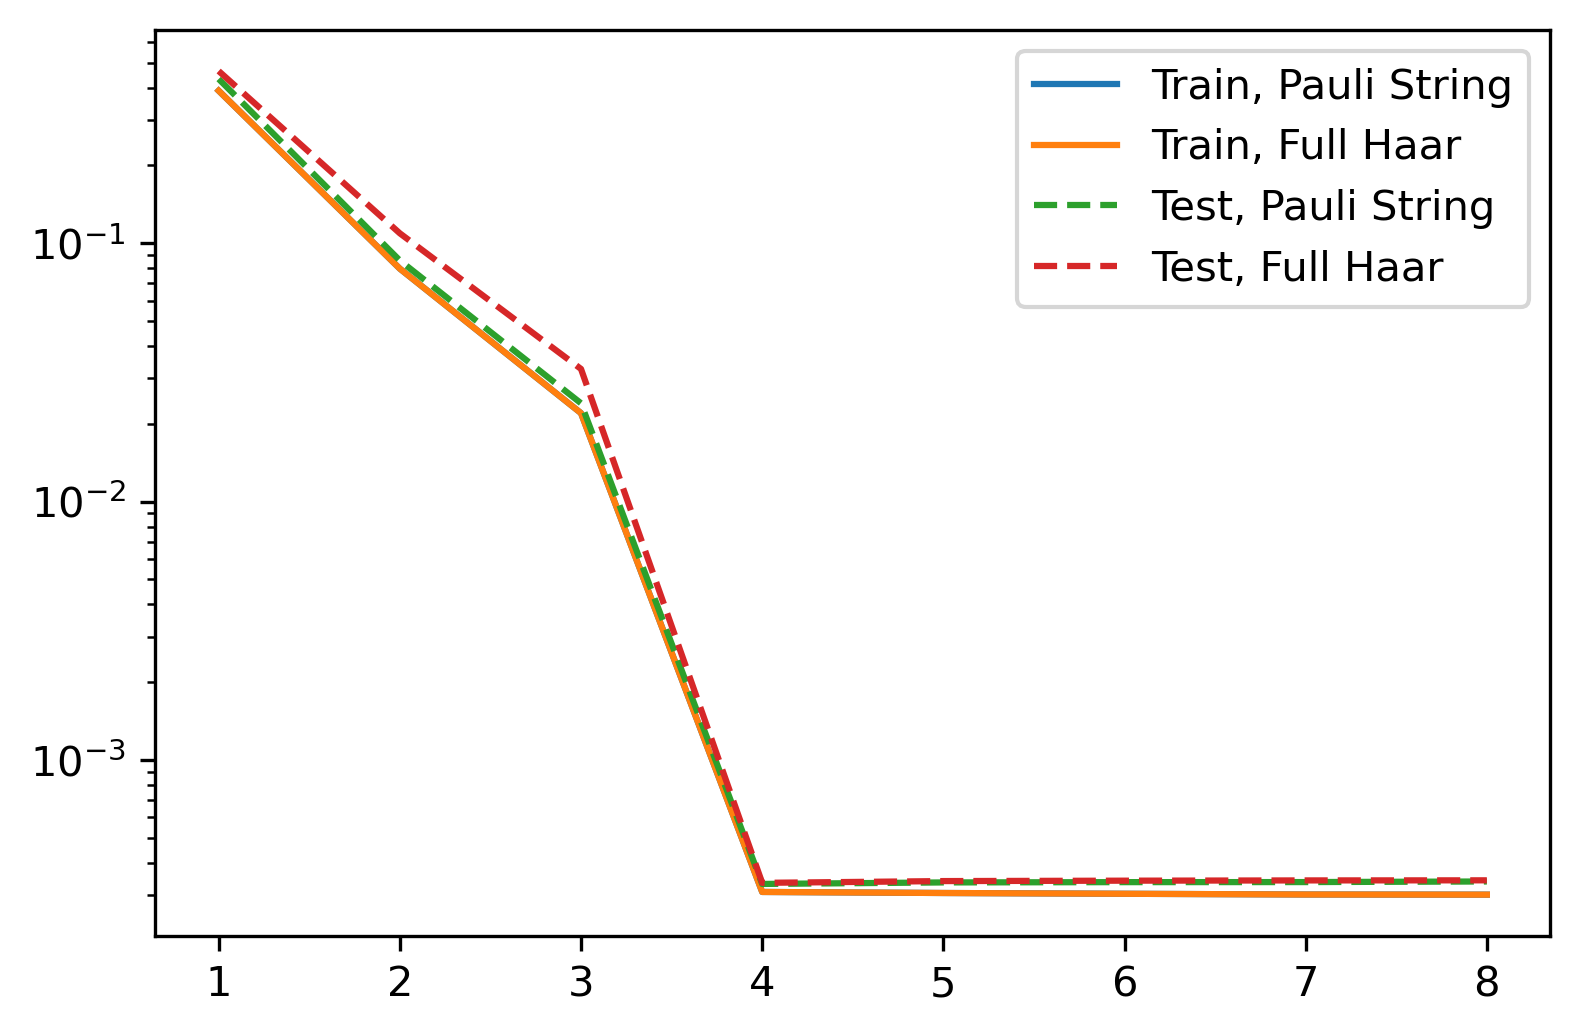

In [14]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,9))
plt.plot(x, np.array(loss_train1))
#plt.plot(x, np.array(loss_train2))
plt.plot(x, np.array(loss_train3))
plt.plot(x, np.array(loss_test1),"--")
#plt.plot(x, np.array(loss_test2),"--")
plt.plot(x, np.array(loss_test3),"--")
#plt.legend(["Train, Pauli String", "Train, Haar String", "Train, Full Haar", "Test, Pauli String", "Test, Haar String", "Test, Full Haar"])
plt.legend(["Train, Pauli String", "Train, Full Haar", "Test, Pauli String", "Test, Full Haar"])

plt.yscale("log")

plt.show()

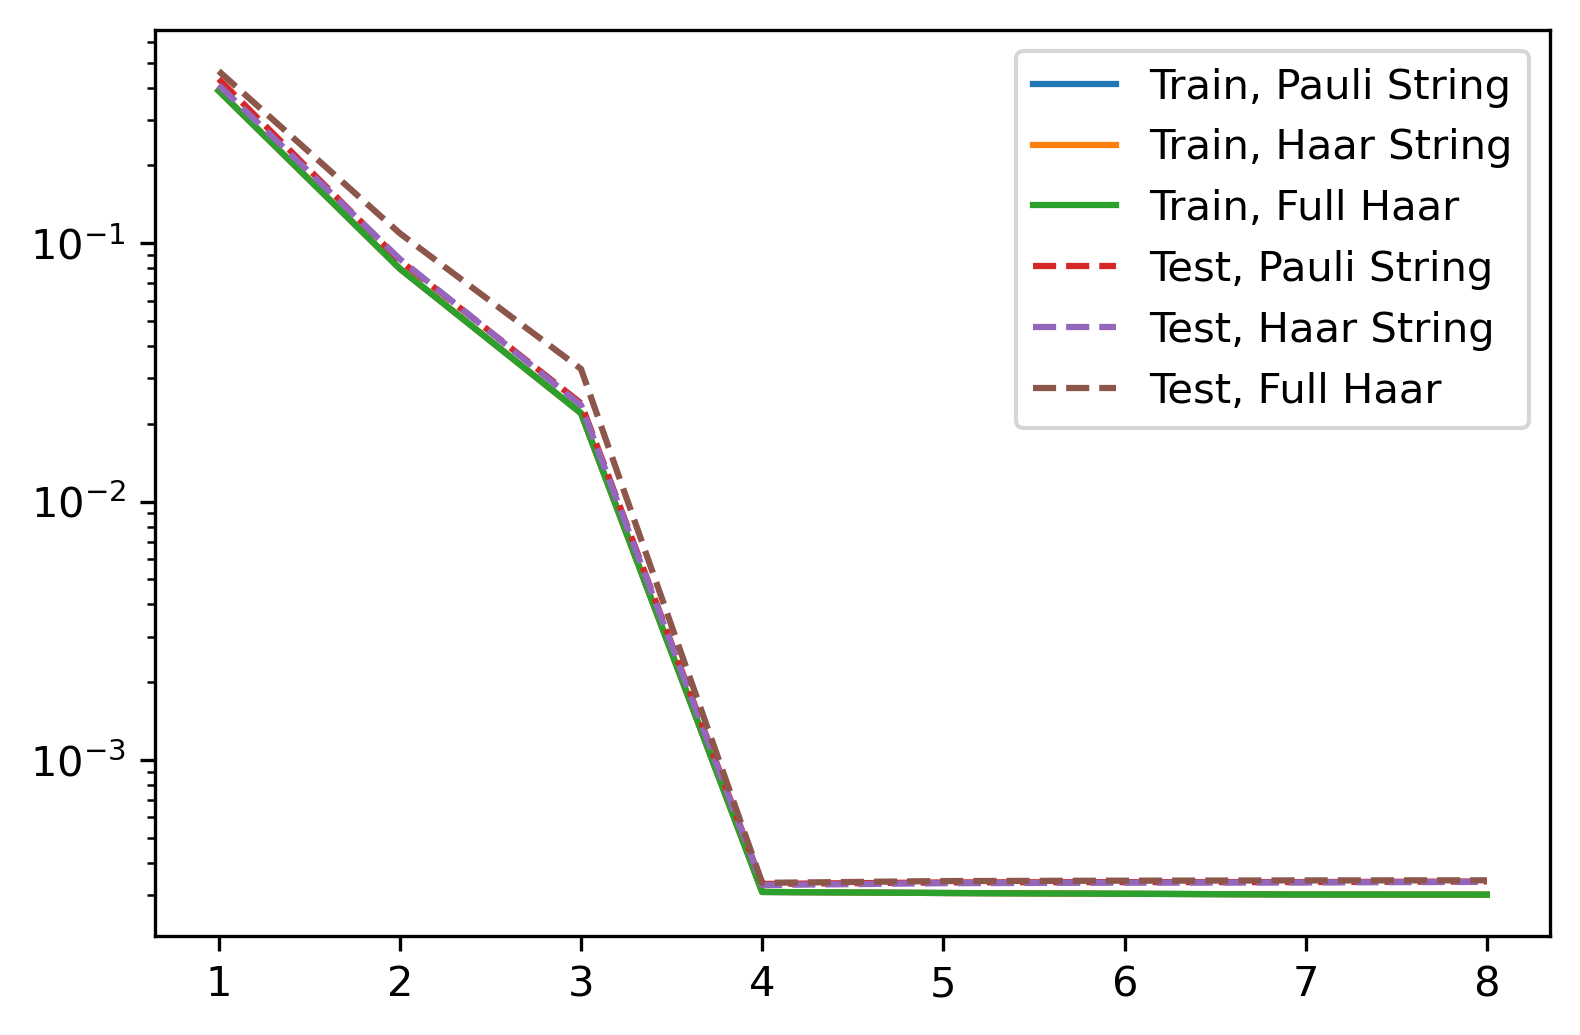

In [9]:
fig = plt.figure(figsize=(6,4), dpi = 300, facecolor='w', edgecolor='k')
x = list(range(1,9))
plt.plot(x, np.array(loss_train1))
plt.plot(x, np.array(loss_train2))
plt.plot(x, np.array(loss_train3))
plt.plot(x, np.array(loss_test1),"--")
plt.plot(x, np.array(loss_test2),"--")
plt.plot(x, np.array(loss_test3),"--")
plt.legend(["Train, Pauli String", "Train, Haar String", "Train, Full Haar", "Test, Pauli String", "Test, Haar String", "Test, Full Haar"])

plt.yscale("log")

plt.show()

## SPAM recovery

In [4]:
n = 3
d = 2**n

N = 200

#Pauli Strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

inputs_map1, _ = generate_pauli_circuits(n=n, N=N)


#Unoptimized Sphere strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings = SphereStrings(N=2*N, n=n)

_, U2 = strings.generate_circuits()
inputs_map2 = [U2[:N], U2[N:]]


#Optimized Sphere Strings
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

strings1 = SphereStrings(N=N, n=n)
strings1.optimize(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

tf.Tensor((0.08764314861310517+2.8850349999490184e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08721764504987556+1.897699608424517e-18j), shape=(), dtype=complex128)
tf.Tensor((0.0868070451865298+5.731332500345772e-18j), shape=(), dtype=complex128)
tf.Tensor((0.086416204610015+1.2577485422825195e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08604673392666476+5.13162822395366e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08569922828447477-4.7469054084469436e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08537376496330587-1.6933401297303824e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08507009508799362-1.0819619977673896e-18j), shape=(), dtype=complex128)
tf.Tensor((0.0847877354742431+7.055897021288386e-19j), shape=(), dtype=complex128)
tf.Tensor((0.0845260223071796+9.327770889842703e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08428413737145743+4.841620519230465e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08406113537620306-1.2077076254755168e-18j), shape=(), dtype=comp

tf.Tensor((0.08110347885472054+1.1226487119319445e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08110178411909325-1.8244037902453043e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08110013769947591-2.4607753214657184e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08109853739761672+4.504418721961638e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08109698118296757-2.9289913059632143e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08109546716729682-1.5469065714266631e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08109399359328699+1.5211389187766598e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08109255880763265-1.5612323227754642e-19j), shape=(), dtype=complex128)
tf.Tensor((0.08109116125653718+2.6394786594561377e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08108979946329357-3.2881487690445944e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08108847203685579-1.7327395710392457e-18j), shape=(), dtype=complex128)
tf.Tensor((0.08108717765087362+2.3207811658105046e-18j), shape=(),

KeyboardInterrupt: 